In [30]:
from IPython.display import Javascript

# JavaScript 코드 삽입을 통해 일정 시간마다 클릭 이벤트 발생
display(Javascript('''
    function ClickConnect() {
        console.log("Clicked to prevent Colab from disconnecting");
        document.querySelector("colab-toolbar-button#connect").click();
    }
    setInterval(ClickConnect, 1000 * 60 * 5); // 5분마다 클릭 이벤트 발생
'''))

<IPython.core.display.Javascript object>

In [31]:
# !pip install datasets
# !pip install evaluate
# !pip install optuna

In [32]:
# 기본 라이브러리
import os                                    # 운영 체제 관련 기능 제공
import copy                                  # 객체 복사 관련 모듈
import numpy as np                           # 수학 및 배열 연산
import pandas as pd                          # 데이터 처리 및 분석
import shutil                                # 파일 및 디렉터리 관리
import warnings                              # 경고 제어 모듈
from itertools import product                # 반복 가능한 객체의 모든 조합 생성

# Scikit-Learn
from sklearn.model_selection import KFold, StratifiedKFold, ParameterGrid      # 교차 검증 및 파라미터 그리드 탐색
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,                   # 분류 성능 지표
    confusion_matrix, ConfusionMatrixDisplay, classification_report            # 혼동 행렬 및 분류 보고서
)

# Optuna
import optuna                                 # 하이퍼파라미터 최적화 라이브러리

# PyTorch 및 Hugging Face Transformers
import torch                                  # PyTorch 딥러닝 라이브러리
from torch.utils.data import Dataset, DataLoader, random_split                # 데이터셋 및 데이터 로더
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,                        # 사전 학습 토크나이저 및 모델
    Trainer, TrainingArguments, EarlyStoppingCallback, TrainerCallback,       # 모델 훈련 도구 및 콜백
    logging as transformers_logging                                           # 로깅 설정
)

# Datasets 및 기타 ML 관련 라이브러리
from datasets import Dataset                  # 데이터셋 관리를 위한 라이브러리
import evaluate                               # 모델 평가 관련 라이브러리
import pyarrow as pa                          # 데이터 처리 라이브러리
from imblearn.over_sampling import RandomOverSampler                          # 불균형 데이터 오버샘플링

# 시각화 라이브러리
import matplotlib.pyplot as plt               # 그래프 및 플롯 도구
import seaborn as sns                         # 시각화 라이브러리

# 기타 유틸리티
from tqdm.notebook import tqdm                # Jupyter 노트북용 진행 표시줄
from google.colab import files, drive         # Colab용 파일 및 드라이브 관리
from IPython.display import display, HTML     # IPython 디스플레이 기능

# 환경 설정
warnings.filterwarnings("ignore")             # 경고 메시지 무시
transformers_logging.set_verbosity_error()    # transformers 라이브러리의 로그 수준 설정
os.environ["WANDB_DISABLED"] = "true"         # wandb 비활성화
tqdm.pandas(disable=False)                    # tqdm 진행률 표시 활성화

# Google Drive 마운트
drive.mount('/content/drive')

# 프로젝트 폴더 및 모델 저장 경로 설정
project_folder = '/content/drive/MyDrive/Contest/profanity filtering'
best_model_save_path = os.path.join(project_folder, 'best_model')

# 기존 best_model 폴더가 있으면 삭제
if os.path.exists(best_model_save_path):
    shutil.rmtree(best_model_save_path)

# 새로운 best_model 폴더 생성
os.makedirs(best_model_save_path, exist_ok=True)
print("Best model folder is ready at:", best_model_save_path)

# 헤더 출력 함수 정의
def display_header(text):                     # 텍스트를 헤더로 출력
    display(HTML(f"<h1 style='font-size:24px; color:#333;'>{text}</h1>"))

# 강조된 F1 스코어 메시지 출력 함수 정의
def display_best_model_message(best_f1):
    display(HTML(f"""
    <div style='font-size:1.5em; font-weight:bold; color:#000000; margin:10px 0;'>
        New best model saved with F1 score: {best_f1:.3f}
    </div>
    """))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Best model folder is ready at: /content/drive/MyDrive/Contest/profanity filtering/best_model


In [33]:
# 1. KcELECTRA 모델 및 토크나이저 불러오기
model_name = 'beomi/KcELECTRA-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [34]:
# 2. 경로 설정
base_path = 'drive/MyDrive/Contest/profanity filtering/'
# 3. 데이터 로드 및 필터링
train_df = pd.read_csv(f'{base_path}train.hate.csv')
dev_df = pd.read_csv(f'{base_path}dev.hate.csv')

# 'hate'와 'no' 라벨만 유지
label_mapping = {'hate': 2, 'offensive' : 1, 'no': 0}
train_df = train_df[train_df['label'].isin(['hate', 'no', 'offensive'])].assign(label=lambda df: df['label'].map(label_mapping).astype(int))
dev_df = dev_df[dev_df['label'].isin(['hate', 'no', 'offensive'])].assign(label=lambda df: df['label'].map(label_mapping).astype(int))

X_train = train_df.drop(columns=['label'])  # 피처 데이터만 선택
y_train = train_df['label']                 # 라벨 데이터만 선택

# RandomOverSampler로 오버샘플링 수행
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X_train, y_train)

# 오버샘플링된 데이터셋으로 다시 DataFrame 생성
train_df = pd.concat([X, y], axis=1)

# 오버샘플링 후 라벨 분포 확인
display_header("Oversampled Train dataset label counts:")
display(train_df['label'].value_counts())

,count
label,
2,3486
0,3486
1,3486


In [35]:
# 라벨별 개수 확인
display_header("Train dataset label counts:")
display(train_df['label'].value_counts())

display_header("Dev dataset label counts:")
display(dev_df['label'].value_counts())

,count
label,
2,3486
0,3486
1,3486


,count
label,
1,189
0,160
2,122


In [36]:
# 3. 데이터셋 준비 함수
def preprocess_data(examples):
    return tokenizer(examples['comments'], padding='max_length', truncation=True, max_length=128)

# 4. 데이터셋 변환 및 전처리
train_dataset = Dataset.from_pandas(train_df)
dev_dataset = Dataset.from_pandas(dev_df)

train_dataset = train_dataset.map(preprocess_data, batched=True)
dev_dataset = dev_dataset.map(preprocess_data, batched=True)

# Trainer에 필요한 포맷으로 설정
train_dataset = train_dataset.rename_column("label", "labels")
dev_dataset = dev_dataset.rename_column("label", "labels")
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
dev_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/10458 [00:00<?, ? examples/s]

Map:   0%|          | 0/471 [00:00<?, ? examples/s]

In [37]:
# 5. 과적합 및 과소적합 확인 함수 정의
def is_overfitted(train_accuracy, val_accuracy):
    return train_accuracy > 0.9 and (train_accuracy - val_accuracy) > 0.1

def is_underfitted(train_accuracy, val_accuracy):
    return train_accuracy < 0.6 and val_accuracy < 0.6

# 6. 로그 출력을 억제하는 콜백 정의
class SuppressLoggingCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        control.should_log = False

# 7. EarlyStopping 콜백 클래스 정의
class EarlyStoppingCallback(TrainerCallback):
    def __init__(self, patience=2):
        self.patience = patience
        self.best_score = None
        self.num_bad_epochs = 0

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        current_score = metrics.get('eval_f1')
        if self.best_score is None or current_score > self.best_score:
            self.best_score = current_score
            self.num_bad_epochs = 0
        else:
            self.num_bad_epochs += 1
            if self.num_bad_epochs >= self.patience:
                control.should_training_stop = True

# 평가 함수 정의
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, average="weighted"),
        'recall': recall_score(labels, preds, average="weighted"),
        'f1': f1_score(labels, preds, average="weighted")
    }

# 모델 준비
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

In [38]:
# 기존에 시도한 하이퍼파라미터 조합 기록
existing_params = set(list(product(
    [1e-5, 2e-5, 3e-5, 5e-5, 6e-5],
    [8, 16, 32, 48, 64],
    [1, 2, 3, 4, 5]
)))

# 무조건 들어가야하는 파라미터 조합
additional_params = {
    (6e-05, 64, 2),
    (5e-05, 48, 5),
    (2e-05, 16, 5),
    (3e-05, 16, 4),
    (5e-05, 16, 2),
    (2e-05, 8, 5),
    (1e-05, 8, 1),
    (3e-05, 8, 1),
    (5e-05, 8, 1),
    (6e-05, 8, 1)
}

def filter_new_param_grid(param_grid, existing_params, additional_params):
    """
    기존에 시도한 파라미터 조합을 제외하고 새로운 조합만 필터링하며,
    추가 파라미터에 포함된 기존 파라미터는 다시 결과에 포함시킵니다.

    Parameters:
    param_grid (list): 새로운 하이퍼파라미터 조합 리스트
    existing_params (set): 기존에 시도한 파라미터 조합 집합
    additional_params (set): 추가적으로 고려해야 할 파라미터 조합 집합

    Returns:
    list: 새로운 파라미터 조합만 포함된 리스트
    """
    # 기존 조합을 제외한 새로운 조합 필터링
    new_params = [params for params in param_grid if params not in existing_params]

    # 추가 파라미터에 포함된 기존 파라미터를 다시 추가
    readded_params = [params for params in existing_params if params in additional_params]

    # 최종 리스트
    final_params = new_params + readded_params
    return list(set(final_params))


# 테스트용 새로운 하이퍼파라미터 그리드 생성
param_grid = list(product(
    [1e-5, 2e-5, 3e-5, 5e-5, 6e-5],
    [8, 16, 32, 48, 64],
    [1, 2, 3, 4, 5]
))

# 필터링 함수 호출
param_grid = filter_new_param_grid(param_grid, existing_params, additional_params)

In [39]:
best_f1 = 0
best_model = None
results = []

# 최적 모델 저장 경로
best_model_dir = './best_model'
if not os.path.exists(best_model_dir):
    os.makedirs(best_model_dir)

In [40]:
# 그리드 탐색 및 모델 훈련
for lr, batch_size, epochs in tqdm(param_grid, desc="Training Progress", leave=True):
    current_params = pd.Series({
        "learning_rate": lr,
        "batch_size"   : batch_size,
        "epochs"       : epochs
    })

    display(current_params.to_frame().T)

    # 8. 모델 및 하이퍼파라미터 튜닝 설정
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

    training_args = TrainingArguments(
        output_dir            = './results',
        evaluation_strategy   = "epoch",
        save_strategy         = "epoch",
        per_device_train_batch_size = batch_size,
        per_device_eval_batch_size  = batch_size,
        num_train_epochs      = epochs,
        load_best_model_at_end= True,
        learning_rate         = lr,
        logging_dir           = None,
        logging_steps=int(len(train_dataset) / batch_size),
        report_to             = "none",
        disable_tqdm          = False
    )

    trainer = Trainer(
        model           = model,
        args            = training_args,
        train_dataset   = train_dataset,
        eval_dataset    = dev_dataset,
        compute_metrics = compute_metrics,
        callbacks       = [SuppressLoggingCallback(), EarlyStoppingCallback()]
    )

    # 모델 훈련 및 평가
    train_result = trainer.train()
    metrics      = trainer.evaluate()

    # 평가지표들 계산
    train_loss   = train_result.training_loss
    val_acc      = metrics['eval_accuracy']
    val_precision= metrics['eval_precision']
    val_recall   = metrics['eval_recall']
    val_f1       = metrics['eval_f1']

    # 과적합/과소적합 여부 확인
    overfit  = is_overfitted(train_loss, val_acc)
    underfit = is_underfitted(train_loss, val_acc)

    # 모델 저장 조건 확인
    if not overfit and not underfit:
        if val_f1 > best_f1:
            best_f1 = val_f1
            trainer.save_model(best_model_save_path)
            display_best_model_message(best_f1)

    # 결과 저장
    results.append({
        'learning_rate': lr,
        'batch_size'   : batch_size,
        'epochs'       : epochs,
        'train_loss'   : train_loss,
        'val_accuracy' : val_acc,
        'val_precision': val_precision,
        'val_recall'   : val_recall,
        'val_f1'       : val_f1,
        'overfit'      : overfit,
        'underfit'     : underfit
    })

# 모델과 토크나이저를 Google Drive에 다시 저장
model.save_pretrained(best_model_save_path)
tokenizer.save_pretrained(best_model_save_path)

# 결과를 데이터프레임으로 정리하고 출력
results_df = pd.DataFrame(results)
display(results_df)

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

,learning_rate,batch_size,epochs
0,0.00001,8.0,1.0


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.828200,0.691728,0.675159,0.671533,0.675159,0.661477


,learning_rate,batch_size,epochs
0,0.00003,8.0,1.0


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.760700,0.668728,0.711253,0.715369,0.711253,0.709128


,learning_rate,batch_size,epochs
0,0.00005,8.0,1.0


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.767000,0.669253,0.717622,0.722047,0.717622,0.710691


,learning_rate,batch_size,epochs
0,0.00003,16.0,4.0


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.821200,0.648680,0.734607,0.735014,0.734607,0.733547
2,0.492500,0.799558,0.711253,0.709278,0.711253,0.705069
3,0.292600,0.926222,0.726115,0.721751,0.726115,0.721998


,learning_rate,batch_size,epochs
0,0.00006,8.0,1.0


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.761800,0.683590,0.736730,0.735030,0.736730,0.732218


,learning_rate,batch_size,epochs
0,0.00002,8.0,5.0


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.783600,0.666694,0.694268,0.690900,0.694268,0.691640
2,0.471200,0.971171,0.683652,0.692384,0.683652,0.677127
3,0.317200,1.489630,0.658174,0.666569,0.658174,0.647502


,learning_rate,batch_size,epochs
0,0.00006,64.0,2.0


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.850900,0.660609,0.711253,0.708449,0.711253,0.707407
2,0.553400,0.702443,0.713376,0.713855,0.713376,0.706164


,learning_rate,batch_size,epochs
0,0.00005,48.0,5.0


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.800700,0.629220,0.715499,0.713644,0.715499,0.714236
2,0.471100,0.761596,0.690021,0.688225,0.690021,0.683311
3,0.265600,0.893765,0.711253,0.711698,0.711253,0.707515


,learning_rate,batch_size,epochs
0,0.00002,16.0,5.0


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.805400,0.666925,0.702760,0.705832,0.702760,0.696937
2,0.527700,0.768537,0.698514,0.694296,0.698514,0.690276
3,0.338900,0.868872,0.679406,0.674276,0.679406,0.674510


,learning_rate,batch_size,epochs
0,0.00005,16.0,2.0


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.772300,0.655769,0.726115,0.723962,0.726115,0.724147
2,0.417100,0.839785,0.711253,0.714874,0.711253,0.703676


,learning_rate,batch_size,epochs,train_loss,val_accuracy,val_precision,val_recall,val_f1,overfit,underfit
0,0.00001,8,1,0.828329,0.675159,0.671533,0.675159,0.661477,False,False
1,0.00003,8,1,0.761251,0.711253,0.715369,0.711253,0.709128,False,False
2,0.00005,8,1,0.767576,0.717622,0.722047,0.717622,0.710691,False,False
3,0.00003,16,4,0.535393,0.734607,0.735014,0.734607,0.733547,False,False
4,0.00006,8,1,0.762510,0.736730,0.735030,0.736730,0.732218,False,False
5,0.00002,8,5,0.523971,0.694268,0.690900,0.694268,0.691640,False,False
6,0.00006,64,2,0.701096,0.711253,0.708449,0.711253,0.707407,False,False
7,0.00005,48,5,0.511483,0.715499,0.713644,0.715499,0.714236,False,False
8,0.00002,16,5,0.557333,0.702760,0.705832,0.702760,0.696937,False,False
9,0.00005,16,2,0.594332,0.726115,0.723962,0.726115,0.724147,False,False


In [41]:
# Filter rows where overfit and underfit are False
filtered_df = results_df[(results_df["overfit"] == False) & (results_df["underfit"] == False)]

# Sort by val_f1 in descending order
sorted_df = filtered_df.sort_values(by="val_f1", ascending=False)

# Filter rows where overfit and underfit are False and val_f1 > 0.72
high_f1_df = sorted_df[(sorted_df["val_f1"] > 0.73)]

# Display the filtered DataFrame
display(high_f1_df)


,learning_rate,batch_size,epochs,train_loss,val_accuracy,val_precision,val_recall,val_f1,overfit,underfit
3,0.00003,16,4,0.535393,0.734607,0.735014,0.734607,0.733547,False,False
4,0.00006,8,1,0.762510,0.736730,0.735030,0.736730,0.732218,False,False


In [42]:
{
    (2e-05, 8, 5),
    (2e-05, 16, 5),
    (5e-05, 48, 5),
    (3e-05, 16, 4),
    (5e-05, 16, 2),
    (1e-05, 8, 1),
    (5e-05, 8, 1),
    (6e-05, 8, 1)

}

{(1e-05, 8, 1),
 (2e-05, 8, 5),
 (2e-05, 16, 5),
 (3e-05, 16, 4),
 (5e-05, 8, 1),
 (5e-05, 16, 2),
 (5e-05, 48, 5),
 (6e-05, 8, 1)}

In [43]:
# 모델 저장 경로와 토크나이저 로드
best_model_dir = '/content/drive/MyDrive/Contest/profanity filtering/best_model'  # Google Drive 모델 경로
model = AutoModelForSequenceClassification.from_pretrained(best_model_dir)  # 저장된 모델 로드
tokenizer = AutoTokenizer.from_pretrained(best_model_dir)  # 모델과 함께 저장된 토크나이저 로드

# 테스트 데이터 로드 및 토큰화
test_df = pd.read_csv(f'{base_path}test.hate.no_label.csv')

test_encodings = tokenizer(test_df['comments'].tolist(), padding=True, truncation=True, return_tensors="pt")

# 테스트 데이터셋을 Dataset 형식으로 변환
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask']
})

# Trainer 객체를 사용하여 예측 수행
trainer = Trainer(model=model, tokenizer=tokenizer)
predictions = trainer.predict(test_dataset)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

# 예측 결과를 데이터프레임에 추가하여 확인
test_df['label'] = predicted_labels.numpy()
display(test_df[['comments', 'label']])

,comments,label
0,ㅋㅋㅋㅋ 그래도 조아해주는 팬들 많아서 좋겠다 ㅠㅠ 니들은 온유가 안만져줌 ㅠㅠ,1
1,둘다 넘 좋다~행복하세요,0
2,근데 만원이하는 현금결제만 하라고 써놓은집 우리나라에 엄청 많은데,0
3,원곡생각하나도 안나고 러블리즈 신곡나온줄!!! 너무 예쁘게 잘봤어요,0
4,장현승 얘도 참 이젠 짠하다...,1
...,...,...
969,대박 게스트... 꼭 봐야징~ 컨셉이 바뀌니깐 재미지넹,0
970,성형으로 다 뜯어고쳐놓고 예쁜척. 성형 전 니 얼굴 다 알고있다. 순자처럼 된장냄새...,2
971,분위기는 비슷하다만 전혀다른 전개던데 무슨ㅋㅋㄱ 우리나라사람들은 분위기만 비슷하면 ...,1
972,입에 손가릭이 10개 있으니 징그럽다,2


In [44]:
# 학습 파일이 위치한 Google 드라이브 경로
project_folder = '/content/drive/MyDrive/Contest/profanity filtering'

# 결과 파일 저장 경로 설정
output_file = os.path.join(project_folder, 'test_predictions.csv')

# 예측 결과를 엑셀 파일로 저장
test_df[['comments', 'label']].to_csv(output_file, index=False)
print(f"Predictions saved to Google Drive at {output_file}")

# Colab 로컬 환경에서도 다운로드 가능하게 저장
local_output_file = 'test_predictions.csv'
test_df[['comments', 'label']].to_csv(local_output_file, index=False)
files.download(local_output_file)

Predictions saved to Google Drive at /content/drive/MyDrive/Contest/profanity filtering/test_predictions.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,precision,recall,f1-score,support
no,77.71%,85.00%,81.19%,160
offensive,67.21%,65.08%,66.13%,189
hate,73.45%,68.03%,70.64%,122
accuracy,72.61%,72.61%,72.61%,1
macro avg,72.79%,72.70%,72.65%,471
weighted avg,72.40%,72.61%,72.41%,471


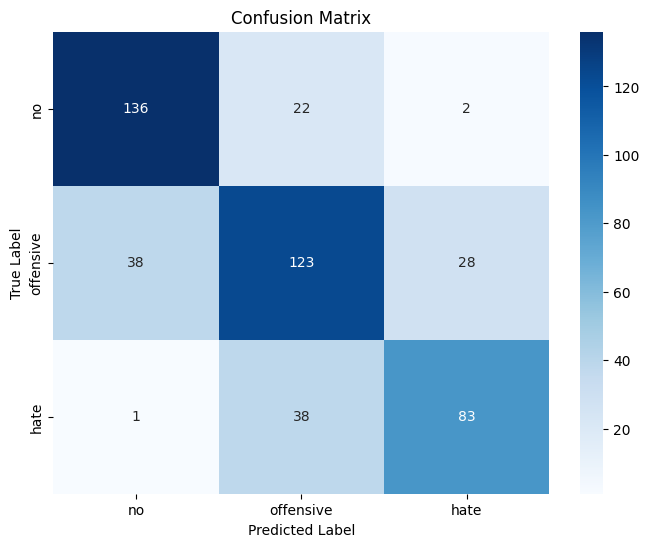

In [45]:
eval_predictions = trainer.predict(dev_dataset)  # 평가 데이터셋으로 대체

true_labels = eval_predictions.label_ids
pred_labels = eval_predictions.predictions.argmax(axis=1)

# 평가지표 출력
report = classification_report(true_labels, pred_labels, target_names=['no', 'offensive', 'hate'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# 스타일 적용하여 출력
styled_report = report_df.style.background_gradient(cmap='Blues').format({
    'precision': '{:.2%}',
    'recall': '{:.2%}',
    'f1-score': '{:.2%}',
    'support': '{:.0f}'
}).set_caption("Classification Report").set_properties(**{
    'border': '1px solid black',
    'color': 'black',
    'text-align': 'center'
})
display(styled_report)

# 혼동 행렬 시각화
conf_matrix = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['no', 'offensive', 'hate'], yticklabels=['no', 'offensive', 'hate'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
os._exit(0)